# I) IMPORT COMMUNICATION FUNCTIONS

In [1]:
import sys
import os

# Get the current working directory (where the notebook 'my_notebook.ipynb' is located)
notebook_dir = os.getcwd()

# Go up one level to the 'Communication_Functions' directory
module_dir = os.path.dirname(notebook_dir)

# Append the 'Communication_Functions' directory to the sys.path
sys.path.append(module_dir)

# Now you can import the 'communication_functions' module
from communication_functions import *

In [2]:
import pandas as pd

# II) CONNECT TO DEVICES AND CHECK RETURN VALUE

In [3]:
device_serials = serial_start_connections()
device_serials

[Serial<id=0x20896d0bc10, open=True>(port='COM15', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False), Serial<id=0x20896d0bdc0, open=True>(port='COM14', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False), Serial<id=0x20896d0bb20, open=False>(port=None, baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False), None]


[Serial<id=0x20896d0bc10, open=True>(port='COM15', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False),
 Serial<id=0x20896d0bdc0, open=True>(port='COM14', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False),
 Serial<id=0x20896d0bb20, open=False>(port=None, baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False),
 None]

# III) START PSU AND CHECK RETURN VALUE

In [4]:
sucess = send_PSU_enable(device_serials[0], 1)
print(sucess)

b'\x00\xc3\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
----------------- START: TEST CRC -----------------
CRC IN DATA:		49920
CRC CALCULATED:	49920
CRC CHECK:		True
----------------- END: TEST CRC -----------------
--- fct: writeSerialData ---
Data sent successfully
--- end: writeSerialData ---
True


# IV) START PG AND CHECK RETURN VALUE

In [5]:
zerodata = send_PG_enable(device_serials[1], 1)
sucess = send_PG_pulsetimes(device_serials[1])
print(zerodata)
print(sucess)

--- fct: writeSerialData ---
Data sent successfully
--- end: writeSerialData ---
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO 

# A) READ PSU DATA IN A LOOP

In [ ]:
psu_header = ["CRC", "TYPE", "STATUS", "P-SETPOINT", "P-VALUE", "N-SETPOINT", "N-VALUE", "P-CURRENT", "N-CURRENT"]
df_psu = pd.DataFrame(columns=psu_header)

for v in range(0, 45, 5):
    send_PSU_setpoints(device_serials[0], v, v, verbose=0)

    for i in range(600):
        psu_data, psu_crc_status = read_PSU_data(device_serials[0], 0)
    
        # Add a new row to the DataFrame
        new_row = pd.DataFrame([psu_data], columns=psu_header)
        df_psu = pd.concat([df_psu, new_row], ignore_index=True)

df_psu

In [ ]:
# P-SETPOINT & P-VALUE
df_psu.plot(
    title="PSU received data: P",
    y=['P-SETPOINT', 'P-VALUE'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# N-SETPOINT & N-VALUE
df_psu.plot(
    title="PSU received data: N",
    y=['N-SETPOINT', 'N-VALUE'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# P-CURRENT & N-CURRENT
df_psu.plot(
    title="PSU received data: CURRENT",
    y=['P-CURRENT', 'N-CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()

# B) READ PG DATA IN A LOOP

In [ ]:
PG_TYPE_DATASTART = 0x1000
PG_TYPE_DATAEND = 0x1001
PG_TYPE_PULSEDATA = 0x1002
PG_TYPE_ZERODATA = 0x1003

In [ ]:
pg_pulse_header = ["VOLTAGE", "CURRENT"]
df_pg_pulse = pd.DataFrame(columns=pg_pulse_header)

send_PSU_setpoints(device_serials[0], 45, 45, verbose=0)

for i in range(2000):
    pg_data, pg_datatype, pg_crc_status = read_PG_data(device_serials[1], 0)

    if pg_datatype == PG_TYPE_PULSEDATA:
        # Add a new row to the DataFrame
        new_row = pd.DataFrame(pg_data, columns=pg_pulse_header)
        df_pg_pulse = pd.concat([df_pg_pulse, new_row], ignore_index=True)

    if pg_datatype == PG_TYPE_DATASTART:
        for j in range(1000):    # ADD 100 ZERO DATA ROWS
            zero_row = pd.DataFrame([zerodata], columns=pg_pulse_header)
            df_pg_pulse = pd.concat([df_pg_pulse, zero_row], ignore_index=True)

# CORRECT WITH ZERODATA
df_pg_pulse_corrected = df_pg_pulse.copy()
df_pg_pulse_corrected["VOLTAGE"] = df_pg_pulse_corrected["VOLTAGE"] - zerodata[0]
df_pg_pulse_corrected["CURRENT"] = df_pg_pulse_corrected["CURRENT"] - zerodata[0]

# SCALED TO DISPLAY VOLTAGE
df_pg_pulse_scaled = df_pg_pulse_corrected.copy()
df_pg_pulse_scaled["VOLTAGE"] = df_pg_pulse_scaled["VOLTAGE"] * 0.15
df_pg_pulse_scaled["CURRENT"] = df_pg_pulse_scaled["CURRENT"] * 0.15

#df_pg_pulse

In [ ]:
# CURRENT & VOLTAGE
df_pg_pulse.plot(
    title="PG received data: Pulse",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# CURRENT & VOLTAGE CORRECTED (zerodata)
df_pg_pulse_corrected.plot(
    title="PG received data: Pulse corrected data",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# CURRENT & VOLTAGE SCALED
df_pg_pulse_scaled.plot(
    title="PG received data: Pulse corrected data",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()

# READ NEXT PULSE TEST

In [11]:
pg_singlepulse_header = ["VOLTAGE", "CURRENT"]
df_pg_singlepulse = pd.DataFrame(columns=pg_singlepulse_header)

send_PSU_setpoints(device_serials[0], 45, 45, verbose=0)

pg_data, _ = read_next_PG_pulse(device_serials[1])

new_row = pd.DataFrame(pg_data, columns=pg_singlepulse_header)
df_pg_singlepulse = pd.concat([df_pg_singlepulse, new_row], ignore_index=True)


# CORRECT WITH ZERODATA
df_pg_singlepulse_corrected = df_pg_singlepulse.copy()
df_pg_singlepulse_corrected["VOLTAGE"] = df_pg_singlepulse_corrected["VOLTAGE"] - zerodata[0]
df_pg_singlepulse_corrected["CURRENT"] = df_pg_singlepulse_corrected["CURRENT"] - zerodata[0]

# SCALED TO DISPLAY VOLTAGE
df_pg_singlepulse_scaled = df_pg_singlepulse_corrected.copy()
df_pg_singlepulse_scaled["VOLTAGE"] = df_pg_singlepulse_scaled["VOLTAGE"] * 0.15
df_pg_singlepulse_scaled["CURRENT"] = df_pg_singlepulse_scaled["CURRENT"] * 0.15

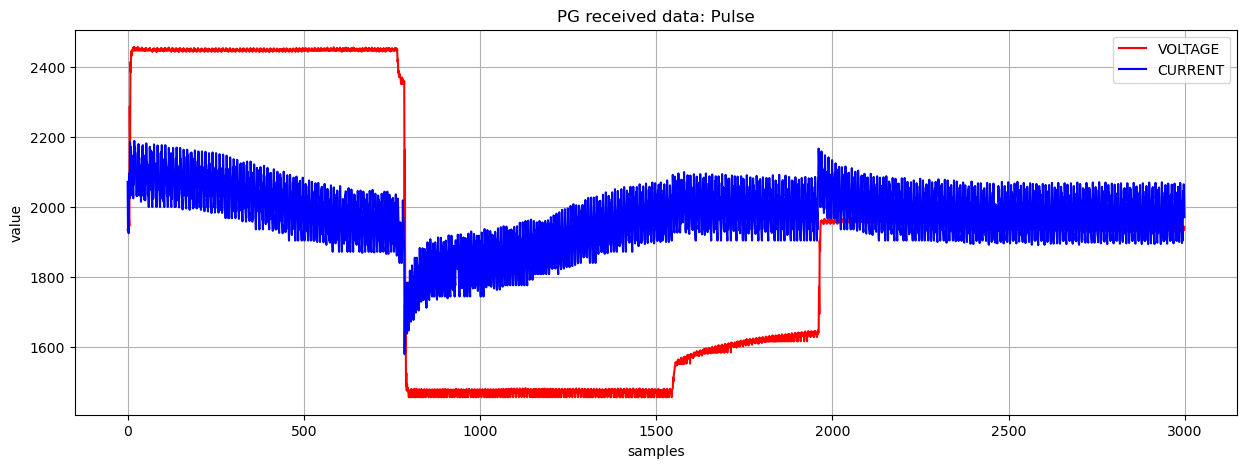

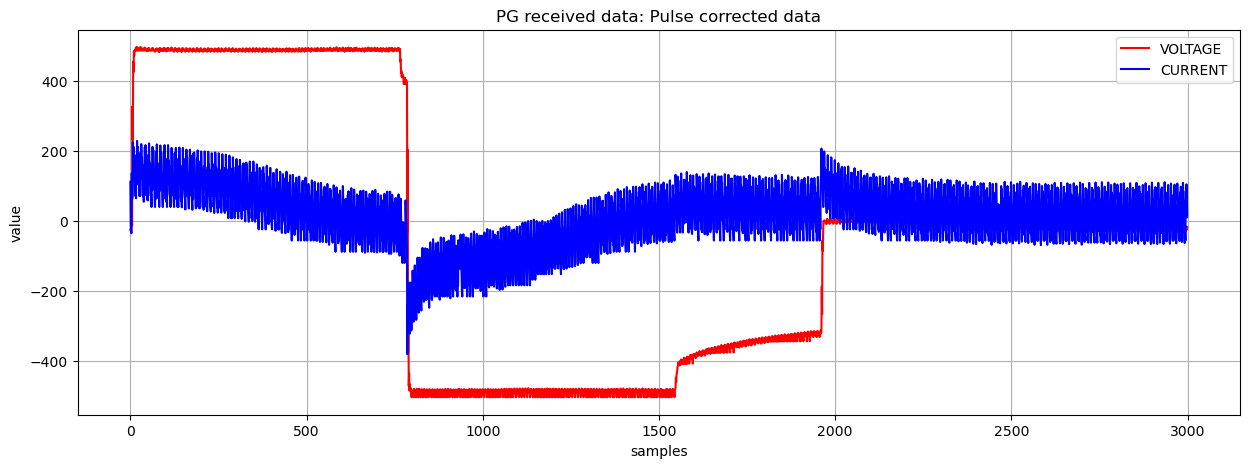

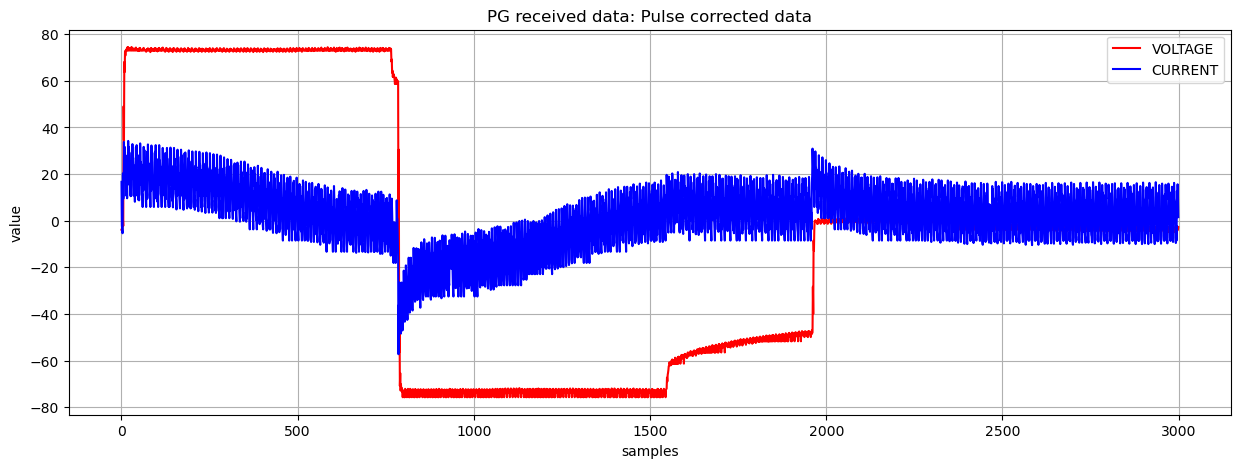

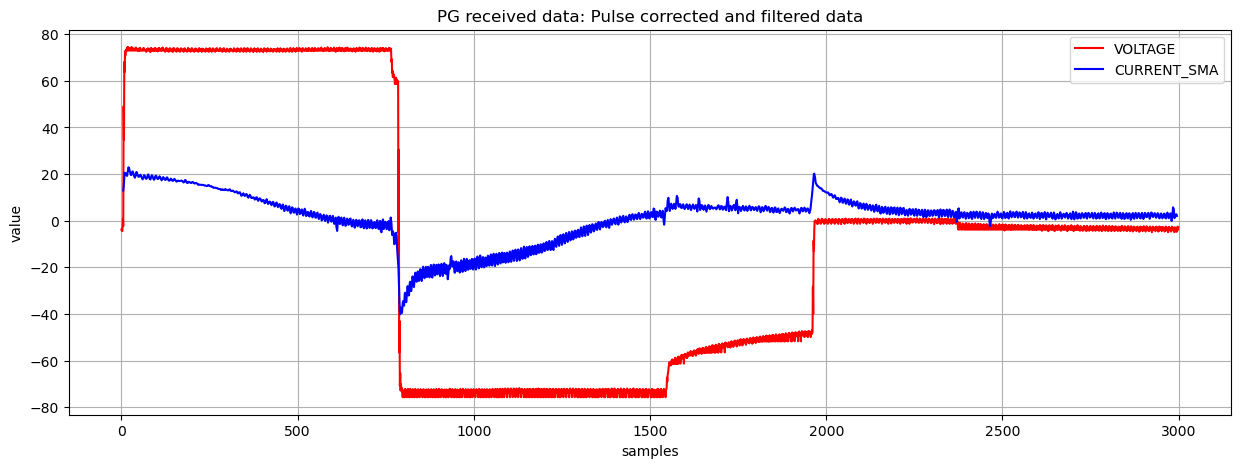

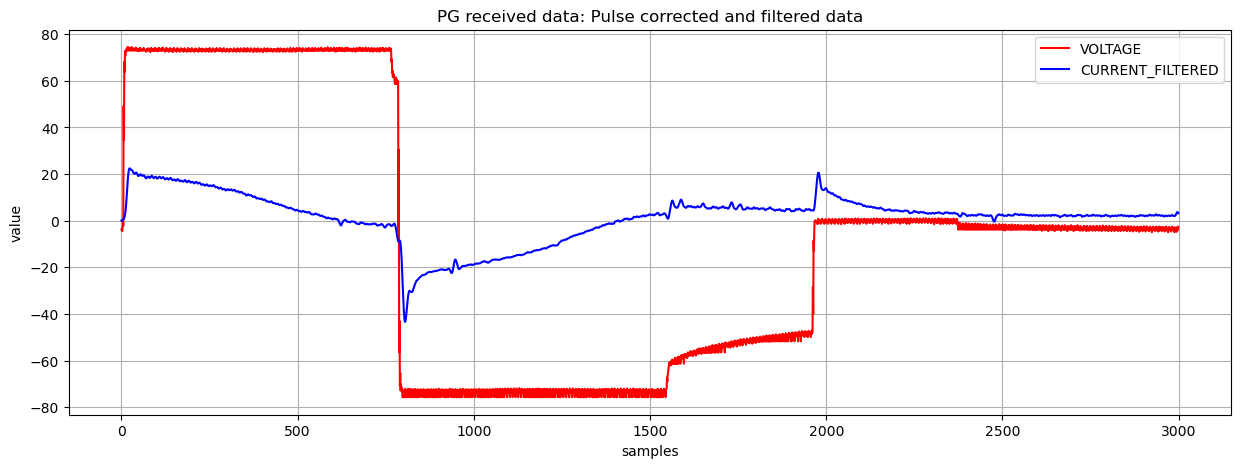

In [12]:
# CURRENT & VOLTAGE
df_pg_singlepulse.plot(
    title="PG received data: Pulse",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# CURRENT & VOLTAGE CORRECTED (zerodata)
df_pg_singlepulse_corrected.plot(
    title="PG received data: Pulse corrected data",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# CURRENT & VOLTAGE SCALED
df_pg_singlepulse_scaled.plot(
    title="PG received data: Pulse corrected data",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()





# FILTER I
# Apply a simple moving average (SMA) filter
window_size = 10  # Choose based on your data's sampling rate and noise characteristics
df_pg_singlepulse_scaled['CURRENT_SMA'] = df_pg_singlepulse_scaled['CURRENT'].rolling(window=window_size, center=True).mean()

# CURRENT & VOLTAGE SCALED
df_pg_singlepulse_scaled.plot(
    title="PG received data: Pulse corrected and filtered data",
    y=['VOLTAGE', 'CURRENT_SMA'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()





# FILTER II
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

# Filtering settings
cutoff_frequency = 500  # Adjust based on your data's frequency content
sampling_rate = 10000  # Assuming 100 Hz sampling rate, adjust to your actual rate

# Apply the filter
df_pg_singlepulse_scaled['CURRENT_FILTERED'] = butter_lowpass_filter(df_pg_singlepulse_scaled['CURRENT'], cutoff_frequency, sampling_rate)

# CURRENT & VOLTAGE SCALED
df_pg_singlepulse_scaled.plot(
    title="PG received data: Pulse corrected and filtered data",
    y=['VOLTAGE', 'CURRENT_FILTERED'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()

In [13]:
send_PG_disable(device_serials[1])

True

In [14]:
send_PSU_disable(device_serials[0])

True

## FLUIDIC TESTS (NEW FUNCTIONS)

In [ ]:
# START PUMPING PUMP1 WITH 1.1ml/s
msg = f'wPF-1-3.000\n'
# Write the message
device_serials[2].write(msg.encode())

In [ ]:
# STOP PUMPING
msg = f'wPF-0-0.000\n'
# Write the message
device_serials[2].write(msg.encode())

In [ ]:
# LED 3 ON
msg = f'wLS-002\n'
# Write the message
device_serials[2].write(msg.encode())

In [ ]:
# MOTOR HOMING
msg = f'wMH-1\n'
# Write the message
device_serials[2].write(msg.encode())

In [ ]:
# RUN BLOOD SYRINGE
msg = f'wMB-0.50-0.50\n'        # wMB-ml-ml/min
# Write the message
device_serials[2].write(msg.encode())

In [ ]:
# TEST MOTOR
msg = f'wMT-1-5000\n'       # MOTOR 1; 5000 STEPS
# Write the message
device_serials[2].write(msg.encode())

In [ ]:
for i in range(600):
    fetchFlowrate(device_serials[2])
    msg = read_flowrate(device_serials[2])
    print(msg)
    time.sleep(0.095)

## 2x PG PARALLEL

In [ ]:
# SHOW AND LIST DEVICES (to get com ports and IDs)
ports = list_ports.comports()
print(ports)

for port in ports:
    print("PORT:\t\t{}".format(port))
    print("VENDOR:\t\t{}".format(port.vid))
    print("PRODUCT:\t{}".format(port.pid))      # 256 = PSU, 512 = PG
    print("------------------------------------------------------")

In [ ]:
# CONNECT PSU
com_psu = "COM3"

ser_psu = serial.Serial(com_psu, 9600, write_timeout=5)
print(ser_psu)

In [ ]:
# ENABLE PSU AND SET VOLTAGE
success = send_PSU_setpoints(ser_psu, 40, 40, 0)
print(success)

sucess = send_PSU_enable(ser_psu, 0)
print(sucess)



In [ ]:
# CONNECT TO BOTH PGs
# IMPORTANT: CHANGE COM PORTS FROM LIST ABOVE

com_hans = "COM5"
com_ceb = "COM4"

# ESTABLISH CONNECTION
ser_hans = serial.Serial(com_hans, 9600, write_timeout=5)
ser_ceb = serial.Serial(com_ceb, 9600, write_timeout=5)

print(ser_hans)
print(ser_ceb)

# ENABLE PG
zerodata_h =send_PG_enable(ser_hans, verbose=2)
zerodata_c =send_PG_enable(ser_ceb, verbose=2)

# SETPOINTS
sucess = send_PG_pulsetimes(ser_hans)
sucess = send_PG_pulsetimes(ser_ceb)

In [ ]:
print(zerodata_h)
print(zerodata_c)

In [ ]:
# NEXT PULSE HANS
pg_singlepulse_header = ["VOLTAGE", "CURRENT"]
df_pg_singlepulse_hans = pd.DataFrame(columns=pg_singlepulse_header)

pg_data, _ = read_next_PG_pulse(ser_hans)

new_row = pd.DataFrame(pg_data, columns=pg_singlepulse_header)
df_pg_singlepulse_hans = pd.concat([df_pg_singlepulse_hans, new_row], ignore_index=True)

print(df_pg_singlepulse_hans)

# CURRENT & VOLTAGE
df_pg_singlepulse_hans.plot(
    title="PG received data: Pulse",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()

In [ ]:
# NEXT PULSE CEB
pg_singlepulse_header = ["VOLTAGE", "CURRENT"]
df_pg_singlepulse_ceb = pd.DataFrame(columns=pg_singlepulse_header)

pg_data, _ = read_next_PG_pulse(ser_ceb)

new_row = pd.DataFrame(pg_data, columns=pg_singlepulse_header)
df_pg_singlepulse_ceb = pd.concat([df_pg_singlepulse_ceb, new_row], ignore_index=True)

print(df_pg_singlepulse_ceb)

# CURRENT & VOLTAGE
df_pg_singlepulse_ceb.plot(
    title="PG received data: Pulse",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()

In [ ]:
ser_hans.close()
ser_ceb.close()

## 3PAC

In [ ]:
device_serials = serial_start_connections()
device_serials

In [ ]:
# DEVICE HANDSHAKE
handshake_3PAC(device_serials[2], print_handshake_message=True)

In [ ]:
# MOTOR n HOMING
msg = "wMH-2\n"
device_serials[2].write(msg.encode())

In [ ]:
# START JOGGING MOTOR 1
msg = "wMJ-2-2-1\n"
device_serials[2].write(msg.encode())

In [ ]:
# STOP JOGGING MOTOR 1
msg = "wMJ-0-0-0\n"
device_serials[2].write(msg.encode())

In [ ]:
# WRITE MOTOR DISTANCE
msg = "wMD-2-10.000-1\n"
device_serials[2].write(msg.encode())


In [ ]:
for i in range(15):
    # START JOGGING MOTOR 1
    msg = "wMJ-3-2-0\n"
    device_serials[2].write(msg.encode())
    time.sleep(2)
    # STOP JOGGING MOTOR 1
    msg = "wMJ-0-0-0\n"
    device_serials[2].write(msg.encode())
    time.sleep(2)

In [ ]:
# JOGGING TESTING PROCEDURE incl. random timing and double clicks


In [ ]:
msg = "wLS-111\n"
device_serials[2].write(msg.encode())

In [ ]:
msg = "wLS-000\n"
device_serials[2].write(msg.encode())

In [ ]:
msg = "wVS-01000000\n"
device_serials[2].write(msg.encode())

In [ ]:
#xxVsVeVp
msg = "wVS-0010000\n"
device_serials[2].write(msg.encode())

In [ ]:
msg = "wPD-1-000\n"
device_serials[2].write(msg.encode())

In [ ]:
for i in range(20):
    msg = "wLS-111\n"
    device_serials[2].write(msg.encode())
    time.sleep(0.5)
    msg = "wLS-000\n"
    device_serials[2].write(msg.encode())
    time.sleep(0.5)

In [ ]:
# RUN PUMP
msg = "wPF-1-2.000-0001\n"
device_serials[2].write(msg.encode())

# READ EVERYTHING
while True:
    # Read a line from the serial port
    serial_message = device_serials[2].readline().decode('utf-8').strip()

    # Display the received message
    print(serial_message)
    device_serials[2].flushInput()

    # Optional: Add a small delay to avoid excessive CPU usage
    time.sleep(0.1)

In [ ]:
# STOP PUMP
msg = "wPF-0-00000-0000\n"
device_serials[2].write(msg.encode())

Valve Test

In [ ]:
message = "wVS-01111111\n"
device_serials[2].write(message.encode())

Pump Test

In [ ]:
message = "wFS-3.00.5.00"
device_serials[2].write(message.encode())

In [ ]:
message = "wFO"
device_serials[2].write(message.encode())

## DISCONNECT

In [ ]:
device_serials[0].close()
device_serials[1].close()
device_serials[2].close()
